### Нємкевич Дар'я. Лабораторна 4. Варіант 7.
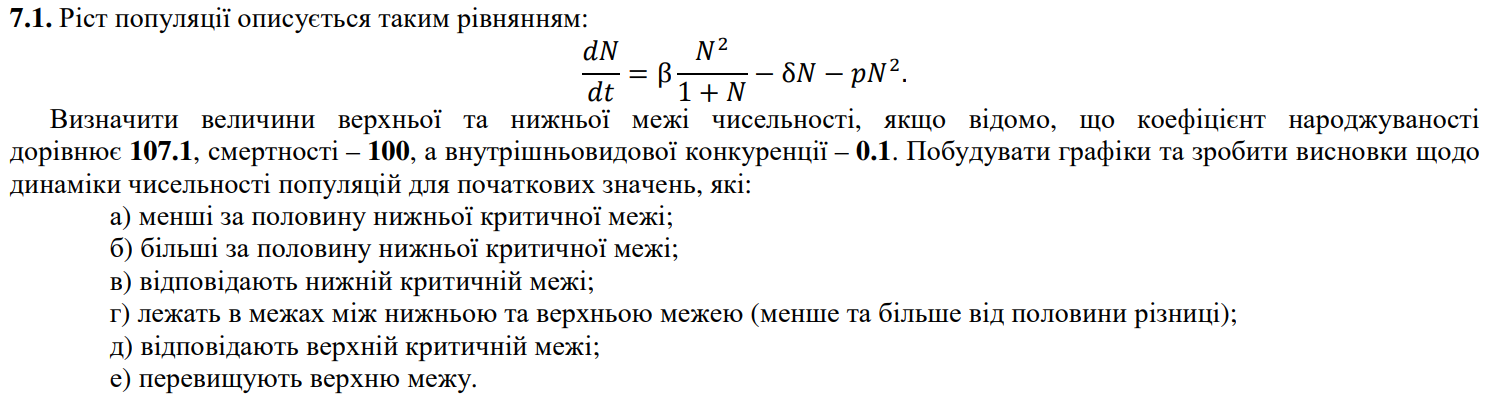

Нижня критична межа: L = 20.000000000000036
Верхня критична межа: H = 49.99999999999991


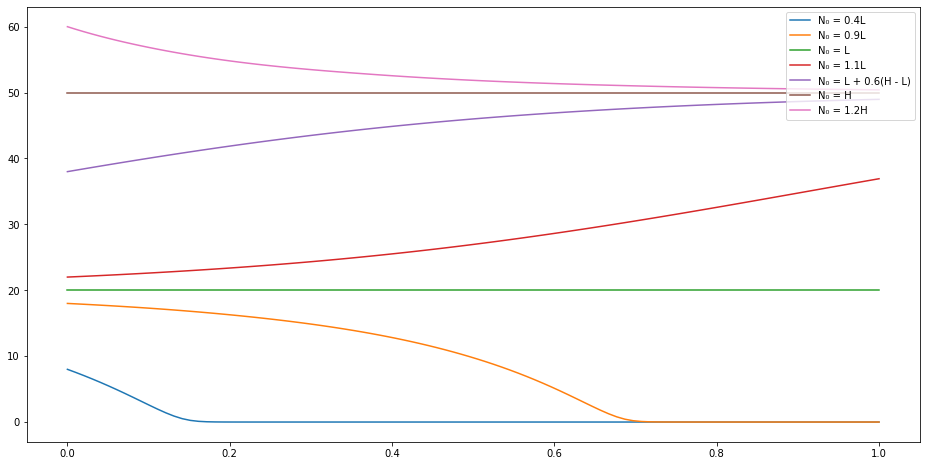

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import sys

birth_coef = 107.1
death_coef = 100
competition = 0.1

def population_func(t, N):
    return birth_coef * (N**2 / (1 + N)) - death_coef * N - competition * N**2
def get_bounds():
    s = birth_coef - death_coef - competition
    c = (s**2 - 4 * death_coef * competition)**0.5
    a, b = (-c - s) / (-2 * competition), (c - s) / (-2 * competition)
    return (min(a, b), max(a, b))

L, H = get_bounds()

print('Нижня критична межа: L =', L)
print('Верхня критична межа: H =', H)

cases = [
    (.4 * L, "N\u2080 = 0.4L"),
    (.9 * L, "N\u2080 = 0.9L"),
    (L, "N\u2080 = L"),
    (1.1*L, "N\u2080 = 1.1L"),
    (L + 0.6 * (H - L), "N\u2080 = L + 0.6(H - L)"),
    (H, "N\u2080 = H"),
    (1.2*H, "N\u2080 = 1.2H")
]

bounds = [0, 1]
t = np.linspace(*bounds, 100)
plt.figure(figsize=(16, 8))
for N0, label in cases:
    N = solve_ivp(population_func, bounds, [N0], t_eval=t).y[0]
    plt.plot(t, N, label=label)

plt.legend(loc='upper right')
plt.show()

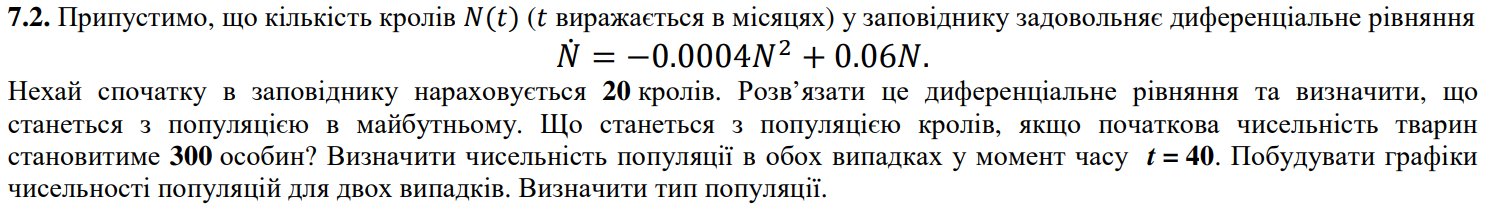

Населення через 40 місяців при стартовій популяції 20: 94
Населення через 40 місяців при стартовій популяції 300: 157


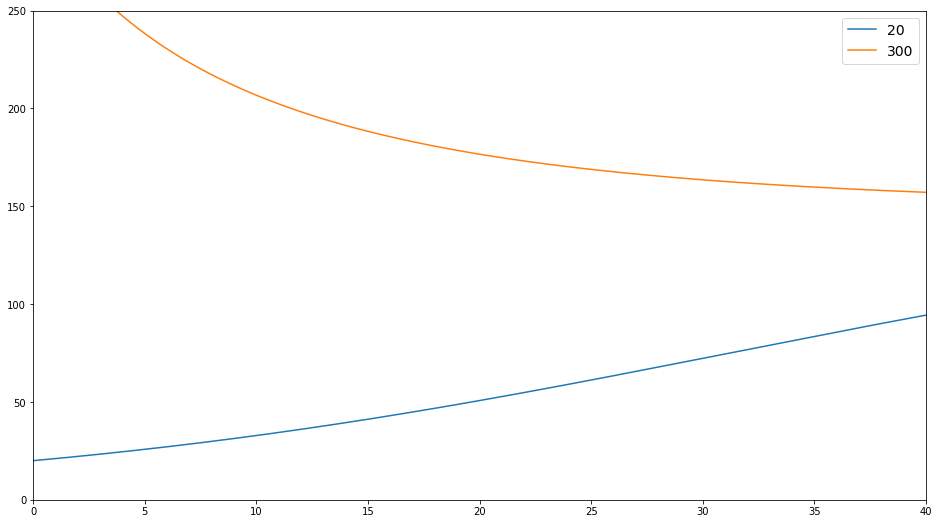

In [21]:
def solve(N0, t0=0, t1=1, h=0.1):
    r = ode(population_func).set_integrator('dopri5').set_initial_value(N0, t0)
    N, t = [N0], [t0]
    while r.successful() and r.t < t1:
        t.append(r.t + h)
        N.append(r.integrate(r.t + h))
    return N, t

population_func = lambda t, N: -0.0004*N**2 + 0.06*N
initial_counts = [20, 300]
t = 40

plt.figure(figsize=(16, 9))
plt.axis([0, 40, 0, 250])

for count in initial_counts:
    N, t = solve(count, 0, 40)
    plt.plot(t, N, label=str(count))
    print("Населення через 40 місяців при стартовій популяції {}: {}".format(count, int(N[-1][0])))
plt.legend(loc='best', prop={'size': 14})
plt.show()

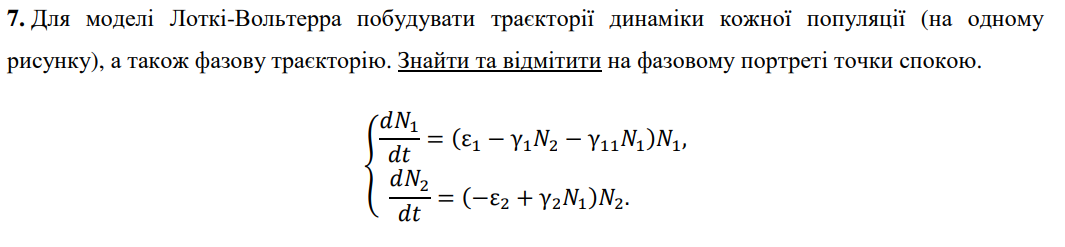

Точки спокою: 
[[10.     0.   ]
 [10.     9.375]
 [ 0.     0.   ]]


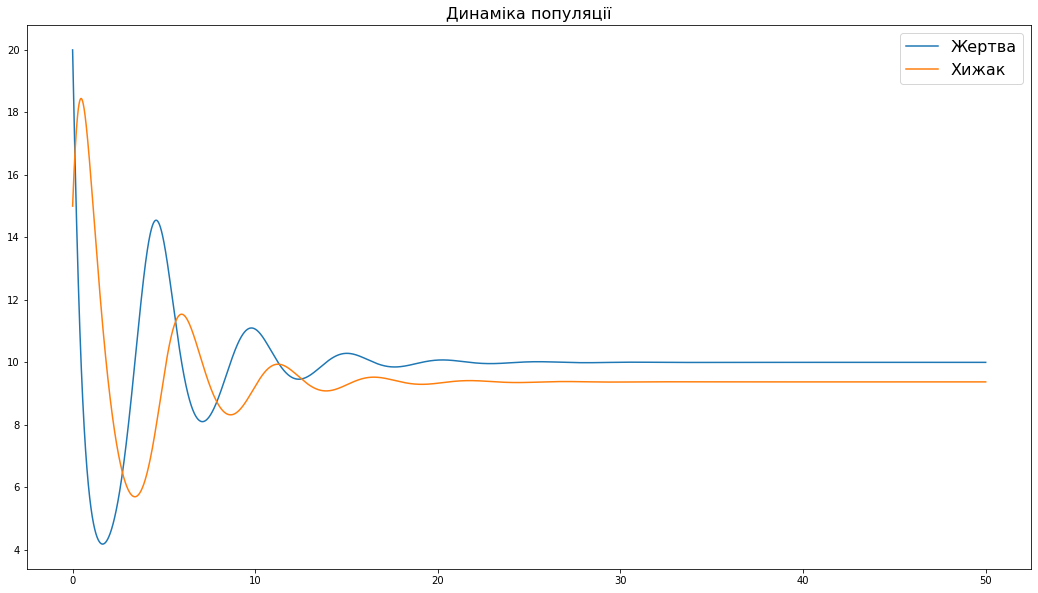

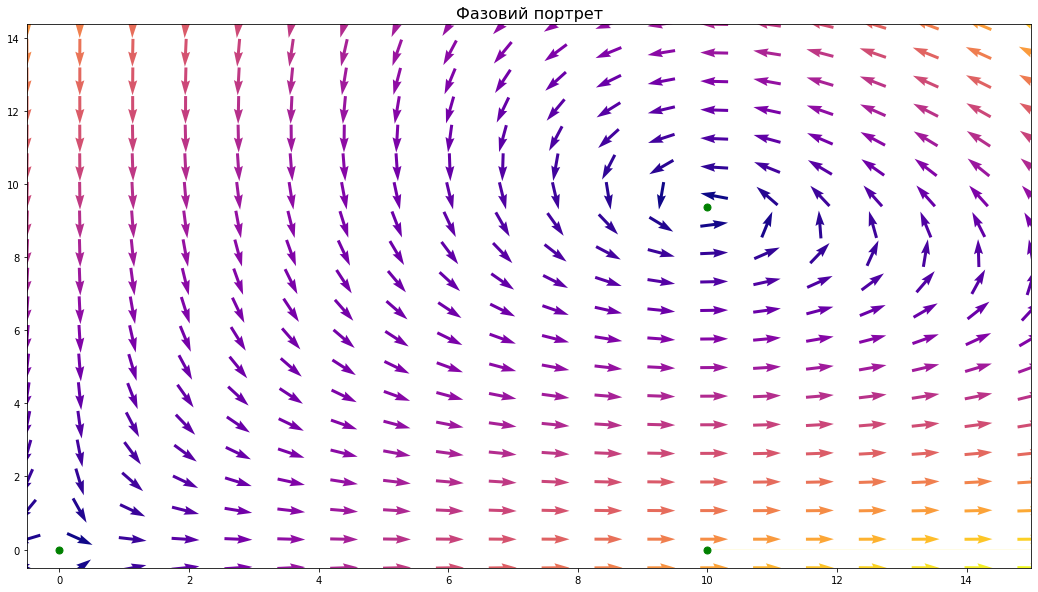

In [52]:
def get_func(func, eps, gamma, gamma2idx):
    def inner_func(N, t=0):
        return func(eps, gamma, gamma2idx, N, t)
    return inner_func
    
    
def plot_population(func, x0, size=50):
    t = np.linspace(0, size, 10000)
    N, _ = odeint(func, x0, t, full_output=True)
    N_rabbits, N_foxes = zip(*N)
    
    plt.figure(figsize=(18, 10))
    plt.title('Динаміка популяції', fontsize=16)
    plt.plot(t, N_rabbits, label='Жертва')
    plt.plot(t, N_foxes, label='Хижак')
    plt.legend(loc='best', fontsize=16)
    
    
def plot_phase(func, s_points, nb_points=20):
    s_point = s_points[0]
    
    x_lim = (max(-0.5, np.min(s_points[:, 0]) - 5), np.max(s_points[:, 0]) + 5)
    y_lim = (max(-0.5, np.min(s_points[:, 1]) - 5), np.max(s_points[:, 1]) + 5)
    
    x, y = np.linspace(*x_lim, nb_points), np.linspace(*y_lim, nb_points)
    X, Y = np.meshgrid(x, y)
    
    dX, dY = func([X, Y], 0)
    M = (np.hypot(dX, dY))
    
    M[M == 0] = 1.
    dX /= M
    dY /= M
    
    values = np.linspace(1, 15, 5)
    vcolors = plt.cm.autumn_r(np.linspace(0.1, 1, len(values)))
    t = np.linspace(0, 50, 10000)
    
    plt.figure(figsize=(18, 10))
    plt.title('Фазовий портрет', fontsize=16)
    for v, col in zip(values, vcolors):
        P0 = s_point * v
        P = odeint(func, P0, t)
        plt.plot(P[:, 0], P[:, 1], lw=0.1 * v, color=col)
    
    plt.quiver(X, Y, dX, dY, M, pivot='mid', cmap=plt.cm.plasma)
    for p in s_points:
        plt.plot(*p, marker='o', markersize=7, color='g')
    
    plt.xlim(x_lim)
    plt.ylim(y_lim)


config = {
    'func': lambda eps, gamma, gamma2idx, N, t: (
        (eps[0] - gamma[0] * N[1] - gamma2idx[0] * N[0]) * N[0],
        (-eps[1] + gamma[1] * N[0]) * N[1]
    ),
    'eps': [2, 1],
    'gamma': [0.16, 0.1],
    'gamma2idx': [0.05],
}
x0 = np.array([20, 15])

def get_s_points(eps, gamma, gamma2idx, **kwargs):
    s_point_0 = np.array([
        eps[1] / gamma[1],
        0
    ])
    s_point_1 = np.array([
        eps[1] / gamma[1],
        (eps[0] / gamma[0]) - ((gamma2idx[0] * eps[1])/(gamma[0] * gamma[1])),
    ])
    return np.array([
        s_point_0,
        s_point_1,
        (0, 0)
    ])

func = get_func(**config)
s_points = get_s_points(**config)

print("Точки спокою: ")
print(s_points)

plot_population(func, x0)
plot_phase(func, s_points)
plt.show()